In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
df = pd.read_parquet("/content/drive/MyDrive/cryptonews.parquet")
print(df.shape)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(31037, 7)


,date,sentiment,source,subject,text,title,url
0,2023-12-19 06:40:41,"{'class': 'negative', 'polarity': -0.1, 'subje...",CryptoNews,altcoin,Grayscale CEO Michael Sonnenshein believes the...,Grayscale CEO Calls for Simultaneous Approval ...,https://cryptonews.comhttps://cryptonews.com/n...
1,2023-12-19 06:03:24,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CryptoNews,blockchain,"In an exclusive interview with CryptoNews, Man...",Indian Government is Actively Collaborating Wi...,https://cryptonews.comhttps://cryptonews.com/n...
2,2023-12-19 05:55:14,"{'class': 'positive', 'polarity': 0.05, 'subje...",CryptoNews,blockchain,According to the Federal Court ruling on Decem...,Judge Approves Settlement: Binance to Pay $1.5...,https://cryptonews.comhttps://cryptonews.com/n...
3,2023-12-19 05:35:26,"{'class': 'positive', 'polarity': 0.5, 'subjec...",CoinTelegraph,blockchain,Some suggest EVM inscriptions are the latest w...,Why a gold rush for inscriptions has broken ha...,https://cointelegraph.com/news/inscriptions-ev...
4,2023-12-19 05:31:08,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CoinTelegraph,ethereum,A decision by bloXroute Labs to start censorin...,‘Concerning precedent’ — bloXroute Labs' MEV r...,https://cointelegraph.com/news/concerning-prec...


In [2]:
import re
import pandas as pd

def clean_text(text):
    if pd.isna(text):
        return ""

    text = text.lower()                        # normalize case
    text = re.sub(r"http\S+", "", text)        # remove URLs
    text = re.sub(r"www\.\S+", "", text)
    text = re.sub(r"[^a-zA-Z0-9\s]", " ", text) # remove special chars
    text = re.sub(r"\s+", " ", text).strip()    # normalize spaces
    return text


In [3]:
df['text']=df['text'].astype(str).apply(clean_text)
df['title']=df['title'].astype(str).apply(clean_text)

In [4]:
df['full_text']=df['title']+''+df['text']

In [5]:
import re

# 1. Name → ticker mapping
mapping = {
    "bitcoin":"BTC", "btc":"BTC",
    "ethereum":"ETH", "eth":"ETH",
    "solana":"SOL", "sol":"SOL",
    "binance":"BNB", "bnb":"BNB",
    "ripple":"XRP", "xrp":"XRP",
    "cardano":"ADA", "ada":"ADA",
    "dogecoin":"DOGE", "doge":"DOGE",
    "polkadot":"DOT", "dot":"DOT",
    "avalanche":"AVAX", "avax":"AVAX",
    "chainlink":"LINK", "link":"LINK",
    "matic":"MATIC", "polygon":"MATIC",
    "atom":"ATOM",
    "litecoin":"LTC", "ltc":"LTC",
    "stellar":"XLM", "xlm":"XLM",
    "filecoin":"FIL", "fil":"FIL",
}

def extract_tickers(text):
    text = text.lower()
    found = set()

    for key, ticker in mapping.items():
        if re.search(rf"\b{key}\b", text):
            found.add(ticker)

    return list(found)

df['tickers'] = df['full_text'].astype(str).apply(extract_tickers)
df = df.explode('tickers').dropna(subset=['tickers'])


In [6]:
df.head()

,date,sentiment,source,subject,text,title,url,full_text,tickers
0,2023-12-19 06:40:41,"{'class': 'negative', 'polarity': -0.1, 'subje...",CryptoNews,altcoin,grayscale ceo michael sonnenshein believes the...,grayscale ceo calls for simultaneous approval ...,https://cryptonews.comhttps://cryptonews.com/n...,grayscale ceo calls for simultaneous approval ...,BTC
2,2023-12-19 05:55:14,"{'class': 'positive', 'polarity': 0.05, 'subje...",CryptoNews,blockchain,according to the federal court ruling on decem...,judge approves settlement binance to pay 1 5 b...,https://cryptonews.comhttps://cryptonews.com/n...,judge approves settlement binance to pay 1 5 b...,BNB
4,2023-12-19 05:31:08,"{'class': 'neutral', 'polarity': 0.0, 'subject...",CoinTelegraph,ethereum,a decision by bloxroute labs to start censorin...,concerning precedent bloxroute labs mev relays...,https://cointelegraph.com/news/concerning-prec...,concerning precedent bloxroute labs mev relays...,ETH
5,2023-12-19 05:25:00,"{'class': 'negative', 'polarity': -0.01, 'subj...",CryptoPotato,bitcoin,yonsei found that during btc s rally in early ...,is this why bitcoin s price rally was halted c...,https://cryptopotato.com/is-this-why-bitcoins-...,is this why bitcoin s price rally was halted c...,BTC
6,2023-12-19 04:50:11,"{'class': 'positive', 'polarity': 0.3, 'subjec...",CryptoNews,bitcoin,cathie wood led ark invest fund sold around 80...,cathie wood s ark invest sells 27 6 million in...,https://cryptonews.comhttps://cryptonews.com/n...,cathie wood s ark invest sells 27 6 million in...,BTC


In [7]:
df['date']=pd.to_datetime(df['date'], format='mixed', errors='coerce')
df=df.sort_values('date')

In [8]:
import ast

def safe_parse(x):
    if isinstance(x, dict):
        return x
    try:
        return ast.literal_eval(x)  # convert string → dict
    except:
        return None

df['sentiment'] = df['sentiment'].apply(safe_parse)

# Drop rows where sentiment parsing failed
df = df.dropna(subset=['sentiment'])

In [9]:
sentiment_daily = (
    df.groupby(['tickers', df['date'].dt.date])
      .agg(
          avg_sentiment=('sentiment', lambda x: x.apply(lambda d: d['polarity']).mean()),
          positive_ratio=('sentiment', lambda x: (x.apply(lambda d: d['class']) == 'positive').mean()),
          negative_ratio=('sentiment', lambda x: (x.apply(lambda d: d['class']) == 'negative').mean()),
          news_count=('title', 'count')
      )
      .reset_index()
      .rename(columns={'date': 'day'})
)

In [10]:
sentiment_daily.shape

(4954, 6)

In [11]:
min_date = sentiment_daily['day'].min()
max_date = sentiment_daily['day'].max()

full_time_index = pd.date_range(start=min_date, end=max_date, freq='D')

In [12]:
continuous_data = []

for ticker in sentiment_daily['tickers'].unique():
    temp = sentiment_daily[sentiment_daily['tickers'] == ticker].copy()

    # Set index for easy reindexing
    temp = temp.set_index('day').reindex(full_time_index)

    # Add ticker column back for missing rows
    temp['tickers'] = ticker

    # Forward-fill sentiment values
    temp['avg_sentiment'] = temp['avg_sentiment'].ffill()
    temp['positive_ratio'] = temp['positive_ratio'].ffill()
    temp['negative_ratio'] = temp['negative_ratio'].ffill()

    # Days without articles → 0 news_count
    temp['news_count'] = temp['news_count'].fillna(0)

    continuous_data.append(temp)

continuous_sentiment = pd.concat(continuous_data).reset_index().rename(columns={'index': 'day'})


In [13]:
continuous_sentiment.head()

,day,tickers,avg_sentiment,positive_ratio,negative_ratio,news_count
0,2021-11-01,ADA,NaN,NaN,NaN,0.0
1,2021-11-02,ADA,NaN,NaN,NaN,0.0
2,2021-11-03,ADA,NaN,NaN,NaN,0.0
3,2021-11-04,ADA,NaN,NaN,NaN,0.0
4,2021-11-05,ADA,NaN,NaN,NaN,0.0


In [14]:
tickers = continuous_sentiment['tickers'].unique().tolist()
tickers

['ADA',
 'ATOM',
 'AVAX',
 'BNB',
 'BTC',
 'DOGE',
 'DOT',
 'ETH',
 'FIL',
 'LINK',
 'LTC',
 'MATIC',
 'SOL',
 'XLM',
 'XRP']

In [15]:
yf_map = {t: f"{t}-USD" for t in tickers}
yf_map

{'ADA': 'ADA-USD',
 'ATOM': 'ATOM-USD',
 'AVAX': 'AVAX-USD',
 'BNB': 'BNB-USD',
 'BTC': 'BTC-USD',
 'DOGE': 'DOGE-USD',
 'DOT': 'DOT-USD',
 'ETH': 'ETH-USD',
 'FIL': 'FIL-USD',
 'LINK': 'LINK-USD',
 'LTC': 'LTC-USD',
 'MATIC': 'MATIC-USD',
 'SOL': 'SOL-USD',
 'XLM': 'XLM-USD',
 'XRP': 'XRP-USD'}

In [16]:
!pip install yfinance --upgrade --quiet
import pandas as pd
import yfinance as yf

price_frames = []

for t in tickers:
    symbol = f"{t}-USD"
    print("Downloading:", symbol)

    dfp = yf.download(symbol, start=str(min_date), end=str(max_date))

    if dfp.empty:
        print("No data for:", t)
        continue

    dfp = dfp[['Open','High','Low','Close','Volume']]
    dfp['returns'] = dfp['Close'].pct_change()
    dfp['tickers'] = t
    dfp['day'] = dfp.index.date
    dfp = dfp.reset_index(drop=True)

    price_frames.append(dfp)

price_data = pd.concat(price_frames, ignore_index=True)
price_data['day'] = pd.to_datetime(price_data['day'])


Downloading: ADA-USD


/tmp/ipython-input-2110022705.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dfp = yf.download(symbol, start=str(min_date), end=str(max_date))
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2110022705.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dfp = yf.download(symbol, start=str(min_date), end=str(max_date))


Downloading: ATOM-USD


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2110022705.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dfp = yf.download(symbol, start=str(min_date), end=str(max_date))


Downloading: AVAX-USD


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2110022705.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dfp = yf.download(symbol, start=str(min_date), end=str(max_date))
[*********************100%***********************]  1 of 1 completed


Downloading: BNB-USD
Downloading: BTC-USD


/tmp/ipython-input-2110022705.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dfp = yf.download(symbol, start=str(min_date), end=str(max_date))
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2110022705.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dfp = yf.download(symbol, start=str(min_date), end=str(max_date))


Downloading: DOGE-USD


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2110022705.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dfp = yf.download(symbol, start=str(min_date), end=str(max_date))


Downloading: DOT-USD


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2110022705.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dfp = yf.download(symbol, start=str(min_date), end=str(max_date))


Downloading: ETH-USD


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2110022705.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dfp = yf.download(symbol, start=str(min_date), end=str(max_date))


Downloading: FIL-USD


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2110022705.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dfp = yf.download(symbol, start=str(min_date), end=str(max_date))


Downloading: LINK-USD


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2110022705.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dfp = yf.download(symbol, start=str(min_date), end=str(max_date))


Downloading: LTC-USD


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2110022705.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dfp = yf.download(symbol, start=str(min_date), end=str(max_date))


Downloading: MATIC-USD


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2110022705.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dfp = yf.download(symbol, start=str(min_date), end=str(max_date))


Downloading: SOL-USD


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2110022705.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dfp = yf.download(symbol, start=str(min_date), end=str(max_date))


Downloading: XLM-USD


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2110022705.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dfp = yf.download(symbol, start=str(min_date), end=str(max_date))


Downloading: XRP-USD


[*********************100%***********************]  1 of 1 completed


In [17]:
price_data.columns = [
    "_".join([str(x) for x in col if x not in [None, ""]])
    if isinstance(col, tuple)
    else str(col)
    for col in price_data.columns
]

price_data=price_data.rename(columns={'day_':'day'})
price_data=price_data.rename(columns={'tickers_':'tickers'})

price_data.head()

,Open_ADA-USD,High_ADA-USD,Low_ADA-USD,Close_ADA-USD,Volume_ADA-USD,returns,tickers,day,Open_ATOM-USD,High_ATOM-USD,...,Open_XLM-USD,High_XLM-USD,Low_XLM-USD,Close_XLM-USD,Volume_XLM-USD,Open_XRP-USD,High_XRP-USD,Low_XRP-USD,Close_XRP-USD,Volume_XRP-USD
0,1.964962,2.015316,1.917960,1.950002,2.649339e+09,NaN,ADA,2021-11-01,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.949818,1.996540,1.934827,1.971377,2.459980e+09,0.010962,ADA,2021-11-02,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.971404,2.144626,1.950845,2.063701,4.722706e+09,0.046832,ADA,2021-11-03,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.064559,2.100966,1.956403,1.984882,3.301214e+09,-0.038193,ADA,2021-11-04,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.984745,2.018975,1.963668,1.986206,2.274852e+09,0.000667,ADA,2021-11-05,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
price_data = price_data.drop(columns=['tickers'], errors='ignore')

In [19]:
price_cols = [c for c in price_data.columns if c not in ['day','returns']]

long_df = price_data.melt(
    id_vars=['day'],
    value_vars=price_cols,
    var_name='variable',
    value_name='value'
)

In [20]:
long_df[['metric', 'ticker']] = long_df['variable'].str.rsplit('_', n=1, expand=True)

In [21]:
price_clean = long_df.pivot_table(
    index=['day', 'ticker'],
    columns='metric',
    values='value'
).reset_index()

In [22]:
price_clean.columns.name = None
price_clean['tickers'] = price_clean['ticker'].str.replace('-USD','', regex=False)
price_clean = price_clean.drop(columns=['ticker'])

In [23]:
display(price_clean.head(50))
price_clean.columns
price_clean.shape

,day,Close,High,Low,Open,Volume,tickers
0,2021-11-01,1.950002,2.015316,1.917960,1.964962,2.649339e+09,ADA
1,2021-11-01,37.357956,38.160053,34.832924,37.232906,6.410246e+08,ATOM
2,2021-11-01,65.072517,66.686165,62.359192,64.499268,5.533989e+08,AVAX
3,2021-11-01,551.255920,552.073669,512.176270,524.738220,2.535580e+09,BNB
4,2021-11-01,61004.406250,62419.003906,59695.183594,61320.449219,3.615057e+10,BTC
5,2021-11-01,0.271728,0.285551,0.264089,0.280123,2.784956e+09,DOGE
6,2021-11-01,49.982254,51.468781,41.810192,42.739792,4.338985e+09,DOT
7,2021-11-01,4324.626953,4377.322266,4160.966797,4288.217285,1.798529e+10,ETH
8,2021-11-01,63.927395,64.446465,60.740227,64.397308,5.894127e+08,FIL
9,2021-11-01,31.565237,31.871412,29.208277,30.002562,1.143381e+09,LINK


(11670, 7)

In [24]:
continuous_sentiment['day'] = pd.to_datetime(continuous_sentiment['day'])
price_clean['day'] = pd.to_datetime(price_clean['day'])

final_data = continuous_sentiment.merge(
    price_clean,
    on=['tickers','day'],
    how='left'
)

In [25]:
print(price_clean.shape)
continuous_sentiment.shape

(11670, 7)


(11685, 6)

In [26]:
print(final_data.shape)
final_data.head(50)

(11685, 11)


,day,tickers,avg_sentiment,positive_ratio,negative_ratio,news_count,Close,High,Low,Open,Volume
0,2021-11-01,ADA,NaN,NaN,NaN,0.0,1.950002,2.015316,1.917960,1.964962,2.649339e+09
1,2021-11-02,ADA,NaN,NaN,NaN,0.0,1.971377,1.996540,1.934827,1.949818,2.459980e+09
2,2021-11-03,ADA,NaN,NaN,NaN,0.0,2.063701,2.144626,1.950845,1.971404,4.722706e+09
3,2021-11-04,ADA,NaN,NaN,NaN,0.0,1.984882,2.100966,1.956403,2.064559,3.301214e+09
4,2021-11-05,ADA,NaN,NaN,NaN,0.0,1.986206,2.018975,1.963668,1.984745,2.274852e+09
5,2021-11-06,ADA,NaN,NaN,NaN,0.0,2.006609,2.039940,1.946815,1.985306,1.883049e+09
6,2021-11-07,ADA,NaN,NaN,NaN,0.0,2.021872,2.036167,1.978159,2.006963,1.871914e+09
7,2021-11-08,ADA,NaN,NaN,NaN,0.0,2.124419,2.138435,2.011635,2.021946,3.157370e+09
8,2021-11-09,ADA,0.03,1.0,0.0,1.0,2.273483,2.375914,2.107469,2.126183,7.356647e+09
9,2021-11-10,ADA,0.03,1.0,0.0,0.0,2.101802,2.359522,1.944602,2.268922,6.436474e+09


In [27]:
final_data = final_data.sort_values(['tickers','day'])
final_data[['Open','High','Low','Close','Volume']] = final_data.groupby('tickers')[
    ['Open','High','Low','Close','Volume']
].ffill()

In [28]:
sent_cols = ['avg_sentiment','positive_ratio','negative_ratio','news_count']

final_data[sent_cols] = final_data.groupby('tickers')[sent_cols].ffill().bfill()
final_data['returns'] = final_data.groupby('tickers')['Close'].pct_change()

In [29]:
final_data.head(50)

,day,tickers,avg_sentiment,positive_ratio,negative_ratio,news_count,Close,High,Low,Open,Volume,returns
0,2021-11-01,ADA,0.03,1.0,0.0,0.0,1.950002,2.015316,1.917960,1.964962,2.649339e+09,NaN
1,2021-11-02,ADA,0.03,1.0,0.0,0.0,1.971377,1.996540,1.934827,1.949818,2.459980e+09,0.010962
2,2021-11-03,ADA,0.03,1.0,0.0,0.0,2.063701,2.144626,1.950845,1.971404,4.722706e+09,0.046832
3,2021-11-04,ADA,0.03,1.0,0.0,0.0,1.984882,2.100966,1.956403,2.064559,3.301214e+09,-0.038193
4,2021-11-05,ADA,0.03,1.0,0.0,0.0,1.986206,2.018975,1.963668,1.984745,2.274852e+09,0.000667
5,2021-11-06,ADA,0.03,1.0,0.0,0.0,2.006609,2.039940,1.946815,1.985306,1.883049e+09,0.010272
6,2021-11-07,ADA,0.03,1.0,0.0,0.0,2.021872,2.036167,1.978159,2.006963,1.871914e+09,0.007606
7,2021-11-08,ADA,0.03,1.0,0.0,0.0,2.124419,2.138435,2.011635,2.021946,3.157370e+09,0.050719
8,2021-11-09,ADA,0.03,1.0,0.0,1.0,2.273483,2.375914,2.107469,2.126183,7.356647e+09,0.070167
9,2021-11-10,ADA,0.03,1.0,0.0,0.0,2.101802,2.359522,1.944602,2.268922,6.436474e+09,-0.075514


In [30]:
final_data.isna().sum()

,0
day,0
tickers,0
avg_sentiment,0
positive_ratio,0
negative_ratio,0
news_count,0
Close,0
High,0
Low,0
Open,0


In [31]:
df=final_data.copy()
df=df.sort_values(['tickers','day'])

In [32]:
df['tickers'].unique()
df.isna().sum().sort_values(ascending=False).head(20)

,0
returns,15
day,0
avg_sentiment,0
tickers,0
positive_ratio,0
negative_ratio,0
Close,0
news_count,0
High,0
Low,0


In [33]:
! pip install pandas_ta
import pandas_ta as ta

df = df.copy()

for t in df['tickers'].unique():

    mask = df['tickers'] == t
    temp = df.loc[mask].copy()

    # === Technical Indicators ===
    df.loc[mask, 'returns'] = temp['Close'].pct_change()

    df.loc[mask, 'SMA_7'] = temp['Close'].rolling(7).mean()
    df.loc[mask, 'SMA_20'] = temp['Close'].rolling(20).mean()
    df.loc[mask, 'SMA_50'] = temp['Close'].rolling(50).mean()

    df.loc[mask, 'EMA_20'] = temp['Close'].ewm(span=20).mean()

    # RSI
    df.loc[mask, 'RSI_14'] = ta.rsi(temp['Close'], length=14).values

    # MACD
    macd = ta.macd(temp['Close'])
    df.loc[mask, 'MACD'] = macd['MACD_12_26_9'].values
    df.loc[mask, 'MACD_signal'] = macd['MACDs_12_26_9'].values
    df.loc[mask, 'MACD_history'] = macd['MACDh_12_26_9'].values

    # ATR
    high = temp['High']
    low = temp['Low']
    close = temp['Close']

    tr = pd.concat([
        (high - low),
        (high - close.shift(1)).abs(),
        (low - close.shift(1)).abs()
    ], axis=1).max(axis=1)

    df.loc[mask, 'ATR_14'] = tr.rolling(14).mean().values

    # OBV
    df.loc[mask, 'OBV'] = ta.obv(temp['Close'], temp['Volume']).values

    # Bollinger Bands
    mid = temp['Close'].rolling(20).mean()
    std = temp['Close'].rolling(20).std()

    df.loc[mask, 'BB_middle'] = mid
    df.loc[mask, 'BB_upper'] = mid + 2 * std
    df.loc[mask, 'BB_lower'] = mid - 2 * std
    df.loc[mask, 'BB_width'] = df.loc[mask, 'BB_upper'] - df.loc[mask, 'BB_lower']

    # Sentiment Features
    df.loc[mask, 'sentiment_lag1'] = temp['avg_sentiment'].shift(1)
    df.loc[mask, 'sentiment_lag3'] = temp['avg_sentiment'].shift(3)
    df.loc[mask, 'sentiment_lag7'] = temp['avg_sentiment'].shift(7)

    df.loc[mask, 'sentiment_roll3'] = temp['avg_sentiment'].rolling(3).mean()
    df.loc[mask, 'sentiment_roll7'] = temp['avg_sentiment'].rolling(7).mean()
    df.loc[mask, 'sent_volatility_7'] = temp['avg_sentiment'].rolling(7).std()

    df.loc[mask, 'sent_shock'] = temp['avg_sentiment'] - temp['avg_sentiment'].shift(1)

    df.loc[mask, 'news_lag1'] = temp['news_count'].shift(1)
    df.loc[mask, 'news_roll3'] = temp['news_count'].rolling(3).mean()
    df.loc[mask, 'news_roll7'] = temp['news_count'].rolling(7).mean()


In [34]:
df_clean = df.groupby("tickers").apply(lambda x: x.dropna()).reset_index(drop=True)
df_clean.shape


/tmp/ipython-input-3843481767.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_clean = df.groupby("tickers").apply(lambda x: x.dropna()).reset_index(drop=True)


(10950, 36)

In [35]:
data=df.copy()
data.shape

(11685, 36)

In [36]:
df=df.sort_values(['tickers','day'])

df['target']=df.groupby('tickers')['returns'].shift(-1)

df['direction']=(df['target']>0).astype(int)

df['target_3d']=df.groupby('tickers')['Close'].shift(-3) /df['Close'] -1

df.shape

(11685, 39)

In [37]:
df = df.dropna().reset_index(drop=True)
df.shape


(10905, 39)

In [38]:
df=df.dropna(subset=['target','target_3d'])
df.shape

(10905, 39)

In [39]:
features = df.drop(columns=['day','tickers','target','direction','target_3d'])
X = features.values
y = df['direction'].values

In [40]:
train_size = int(len(df) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [41]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [42]:
! pip install xgboost
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    tree_method='hist',
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.8/296.8 MB 1.2 MB/s eta 0:00:00


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, ...)

In [43]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = xgb_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.5355341586428244
              precision    recall  f1-score   support

           0       0.56      0.39      0.46      1103
           1       0.52      0.69      0.59      1078

    accuracy                           0.54      2181
   macro avg       0.54      0.54      0.53      2181
weighted avg       0.54      0.54      0.53      2181



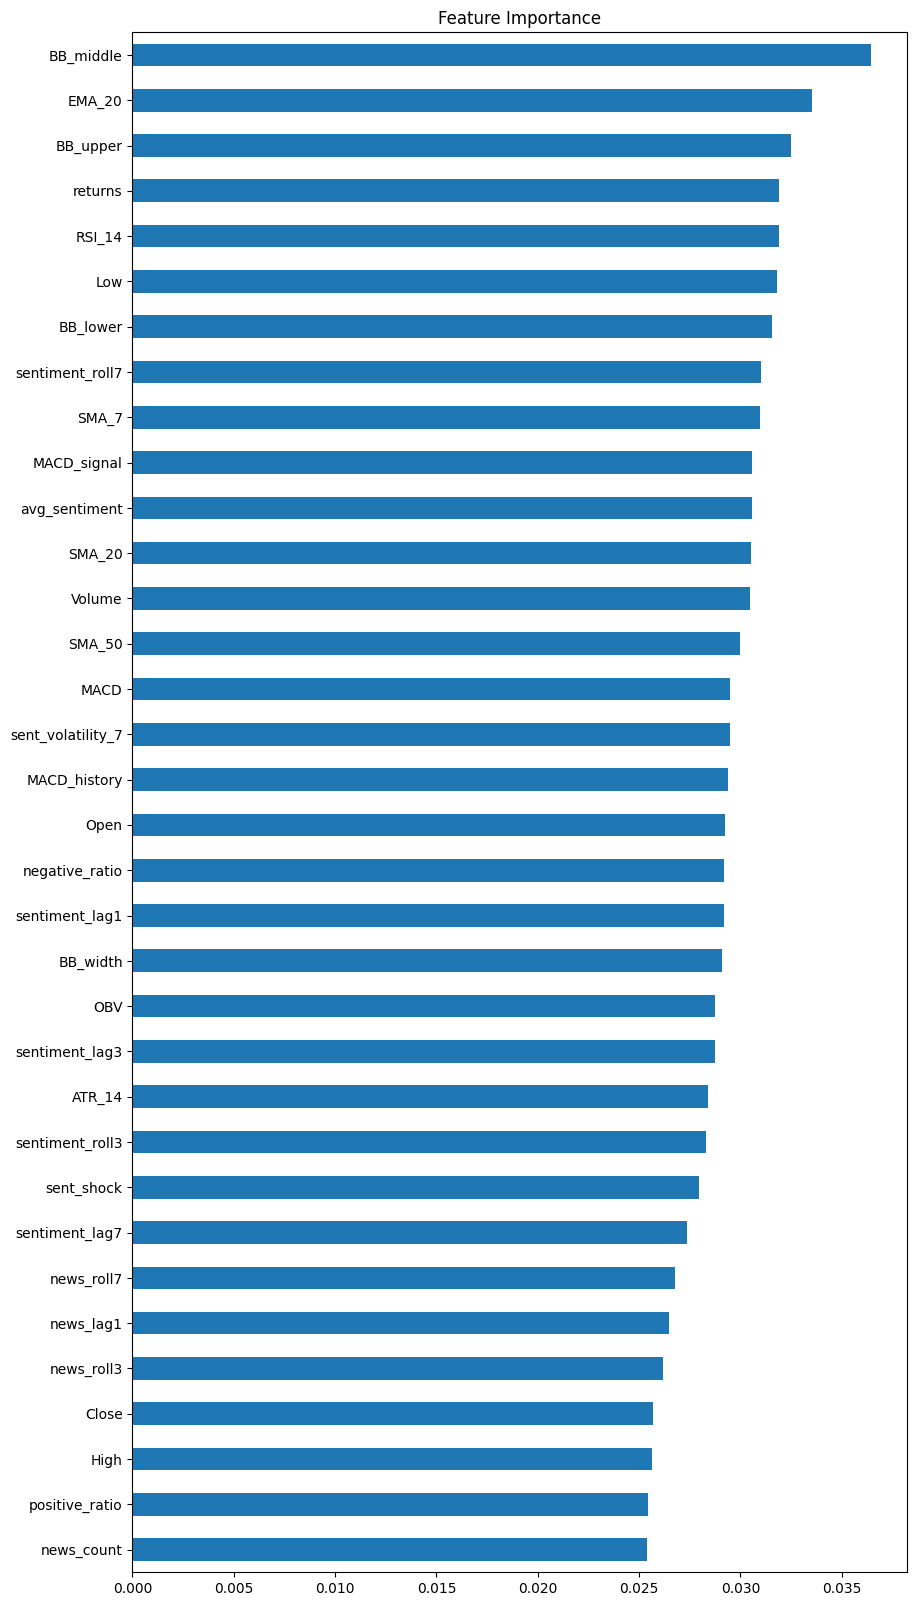

In [44]:
import matplotlib.pyplot as plt
import pandas as pd

feature_names = df.drop(columns=['day','tickers','target','target_3d','direction']).columns
importances = xgb_model.feature_importances_

plt.figure(figsize=(10,20))
pd.Series(importances, index=feature_names).sort_values().plot(kind='barh')
plt.title("Feature Importance")
plt.show()

In [45]:
import numpy as np
import pandas as pd

df = df.sort_values(['tickers', 'day']).reset_index(drop=True)

# Drop rows where target_3d is NaN (very few)
df_model = df.dropna(subset=['target_3d']).reset_index(drop=True)

feature_cols = [
    col for col in df_model.columns
    if col not in ['day', 'tickers', 'target', 'direction', 'target_3d']
]

target_col = 'target_3d'
seq_len = 60  # 60 days history per sample

In [46]:
# Use 80% earliest data as train
cutoff_index = int(len(df_model) * 0.8)
cutoff_day = df_model['day'].sort_values().iloc[cutoff_index]

train_mask = df_model['day'] <= cutoff_day
test_mask  = df_model['day'] > cutoff_day

train_df = df_model[train_mask].copy()
test_df  = df_model[test_mask].copy()


In [47]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_df[feature_cols])

train_features_scaled = scaler.transform(train_df[feature_cols])
test_features_scaled  = scaler.transform(test_df[feature_cols])

# Put back into DataFrames for easy alignment
train_df_scaled = train_df.copy()
test_df_scaled  = test_df.copy()

train_df_scaled[feature_cols] = train_features_scaled
test_df_scaled[feature_cols]  = test_features_scaled


In [48]:
def make_sequences(df_scaled, df_raw, feature_cols, target_col, seq_len):
    X_list, y_list = [], []

    for ticker in df_raw['tickers'].unique():
        mask = df_raw['tickers'] == ticker

        feat_t = df_scaled.loc[mask, feature_cols].values
        target_t = df_raw.loc[mask, target_col].values

        # Skip if too short
        if len(feat_t) <= seq_len:
            continue

        for i in range(len(feat_t) - seq_len):
            X_list.append(feat_t[i:i+seq_len])
            y_list.append(target_t[i+seq_len])

    return np.array(X_list), np.array(y_list)


In [49]:
X_train, y_train = make_sequences(
    train_df_scaled, train_df,
    feature_cols, target_col, seq_len
)

X_test, y_test = make_sequences(
    test_df_scaled, test_df,
    feature_cols, target_col, seq_len
)

In [50]:
X_train.shape, X_test.shape

((7830, 60, 34), (1275, 60, 34))

In [51]:
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout , Input , LayerNormalization, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Attention

# Attention LSTM Model
def build_attention_lstm(seq_len, num_features):

    inputs = Input(shape=(seq_len, num_features))

    # Return all timesteps → needed for attention
    lstm_out = LSTM(64, return_sequences=True)(inputs)

    # Self-attention (query = value = key = lstm_out)
    attention_out = Attention()([lstm_out, lstm_out])

    # Combine attention output + LSTM output
    combined = tf.keras.layers.Concatenate(axis=-1)([lstm_out, attention_out])

    # Reduce sequence to single vector
    flat = Flatten()(combined)

    dense = Dense(64, activation="relu")(flat)
    dense = Dense(32, activation="relu")(dense)
    dense = Dropout(0.2)(dense)

    output = Dense(1)(dense)  # regression (target_3d)

    model = Model(inputs, output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss="mse",
        metrics=["mae"]
    )

    return model

seq_len = X_train.shape[1]
num_features = X_train.shape[2]

model = build_attention_lstm(seq_len, num_features)

model.summary()

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=64,
    verbose=1
)


  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 760.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 89.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.4 MB/s eta 0:00:00
Using cached wheel-0.45.1-py3-none-any.whl (72 kB)


/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 60, 34)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 60, 64)    │     25,344 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 60, 64)    │          0 │ lstm[0][0],       │
│ (Attention)         │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 60, 128)   │          0 │ lstm[0][0],       │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 7680)      │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │    491,584 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         33 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 519,041 (1.98 MB)

 Trainable params: 519,041 (1.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0483 - mae: 0.1367 - val_loss: 0.0059 - val_mae: 0.0525
Epoch 2/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0059 - mae: 0.0544 - val_loss: 0.0064 - val_mae: 0.0538
Epoch 3/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0059 - mae: 0.0522 - val_loss: 0.0056 - val_mae: 0.0507
Epoch 4/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0055 - mae: 0.0517 - val_loss: 0.0056 - val_mae: 0.0513
Epoch 5/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0050 - mae: 0.0497 - val_loss: 0.0059 - val_mae: 0.0518
Epoch 6/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0051 - mae: 0.0503 - val_loss: 0.0057 - val_mae: 0.0512
Epoch 7/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0050 - mae: 0.0493 - val_loss: 0.0062 - val_mae: 0.0546
Epoch 8/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0047 - mae: 0.0474 - val_loss: 0.0057 - val_mae: 0.0523
Epoch 9/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/

In [52]:
df.groupby("tickers").apply(lambda x: x.isna().sum())

/tmp/ipython-input-402329582.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("tickers").apply(lambda x: x.isna().sum())


,day,tickers,avg_sentiment,positive_ratio,negative_ratio,news_count,Close,High,Low,Open,...,sentiment_roll3,sentiment_roll7,sent_volatility_7,sent_shock,news_lag1,news_roll3,news_roll7,target,direction,target_3d
tickers,,,,,,,,,,,,,,,,,,,,,
ADA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ATOM,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AVAX,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BNB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BTC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DOGE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DOT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ETH,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FIL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_pred_lstm = model.predict(X_test).flatten()

mse = mean_squared_error(y_test, y_pred_lstm)
mae = mean_absolute_error(y_test, y_pred_lstm)

print("MSE:", mse)
print("MAE:", mae)

# Optional: directional accuracy from LSTM
lstm_dir_true = (y_test > 0).astype(int)
lstm_dir_pred = (y_pred > 0).astype(int)

from sklearn.metrics import accuracy_score
print("LSTM directional accuracy:", accuracy_score(lstm_dir_true, lstm_dir_pred))


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
MSE: 0.006810282567519228
MAE: 0.05809502689975018
LSTM directional accuracy: 0.49333333333333335


In [62]:
from sklearn.metrics import accuracy_score
final_pred=0.6*y_pred+ 0.4*y_pred_lstm
final_direction=(final_pred>0.5).astype(int)

y_test_bin = (y_test > 0).astype(int)
acc = accuracy_score(y_test_bin, final_direction)

In [63]:
print(f'Accuracy :{acc}')

Accuracy :0.3835294117647059


In [65]:
import joblib
joblib.dump(xgb_model, "crype2_xgboost.pkl")
model.save("crype2_lstm.h5")

In [66]:
df.to_csv("crype2_final_dataset.csv", index=False)